In [1]:
import torch
import torchvision.models as models
import h5py 
from logger import Logger
from torchvision.transforms import transforms 
import torch.utils.data as data
import numpy as np 
import pdb
import matplotlib.pyplot as plt
%matplotlib inline
import torch.nn as nn 
import torch.optim as optim 
from torch.autograd import Variable
import shutil
import os 
import random
import torch.nn.functional as F

/home/aashi/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
class FrameDataset(data.Dataset):
    
    def __init__(self, f, transform=None, test = False):
        self.f = f 
        self.transform = transform 
        self.test = test
        
    def __getitem__(self, index):

        rgb = np.array(self.f["rgb"][index])
        label = np.array((self.f["labels"][index] - self.f["Mean"])/self.f["Variance"])
        
        t_rgb = torch.zeros(3, 224, 224)
        
        prob = random.uniform(0, 1)
        prob2 = random.uniform(0, 1)

        if self.transform is not None:
            if (prob > 0.5 and not self.test):
                flip_transform = transforms.Compose([transforms.ToPILImage(), transforms.RandomHorizontalFlip(1.0)])
                rgb[:,:,:] = flip_transform(rgb[:,:,:])
            if (prob2 > 0.5 and not self.test):
                color_jitter_transform = transforms.Compose([transforms.ToPILImage() ,transforms.ColorJitter(brightness = 0.5, contrast = 0.5, saturation = 0.5, hue = 0.2)])
                rgb[:,:,:] = color_jitter_transform(rgb[:,:,:])

            t_rgb[:,:,:] = self.transform(rgb[:,:,:])                
        
        return rgb, t_rgb, label
    
    def __len__(self):
        return len(self.f["rgb"])

In [3]:
def load_model_weights(MODEL_PATH):
    checkpoint_dict = torch.load(MODEL_PATH)
    model.load_state_dict(checkpoint_dict)
    
def save_model_weights(epoch_num):
    model_file = '/mnt/hdd1/aashi/SingleImage6s_' + str(epoch_num).zfill(3)
    torch.save(model.state_dict(), model_file)

model = models.vgg16(pretrained=True)
num_final_in = model.classifier[-1].in_features
NUM_CLASSES = 20
model.classifier[-1] = nn.Linear(num_final_in, NUM_CLASSES)

model_path = '/home/aashi/the_conclusion/model_files/' + 'vgg_on_voc' + str(800)
load_model_weights(model_path)

model.classifier[-1] = nn.Linear(num_final_in, 1) ## Regressed output
num_features = model.classifier[6].in_features
features = list(model.classifier.children())[:-1] # Remove last layer
features.extend([nn.Linear(num_features, 2048), nn.ReLU(), nn.Linear(2048, 1)]) # Add our layer with 4 outputs
model.classifier = nn.Sequential(*features) # Replace the model classifier

epoch_num = 47 ## Absolute mean error = 0.3022 
MODEL_PATH = '/mnt/hdd1/aashi/SingleImage6s_' + str(epoch_num).zfill(3)
load_model_weights(MODEL_PATH)

In [4]:
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [5]:
model = model.cuda()
hfp_test = h5py.File('/mnt/hdd1/aashi/cmu_data/SingleImageTest.h5', 'r')
mean = hfp_test["Mean"][()]
var = hfp_test["Variance"][()]
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
test_loader = data.DataLoader(FrameDataset(f = hfp_test, transform = transforms.Compose([transforms.ToTensor(), normalize]), test = True), 
                               batch_size=1)

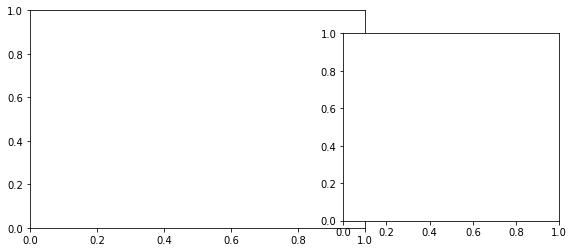

In [6]:
import cv2
model.eval()
n = []
i = 0
prediction = []
groundTruth = []

ax1 = plt.axes()
ax2 = plt.axes([0.85, 0.15, 0.5, 0.65])

err = []

for iter, (img, rgb, label) in enumerate(test_loader, 0):
    rgb = rgb.float().cuda()
    label = label.float().cuda()
    label = label.unsqueeze(-1)
    outputs = model(rgb)
    
    pred = outputs[0].data.cpu().numpy()*var + mean 
    gt = label[0].data.cpu().numpy()*var + mean 
    
    if (gt < 4.0):
        continue
    
    err.append(abs(pred[0] - gt[0]))
    
    pred = round(pred[0], 2)
    gt = round(gt[0], 2)
    
#     n.append(i)
#     prediction.append(pred)
#     groundTruth.append(gt)
    
#     prediction = prediction[-30:]
#     groundTruth = groundTruth[-30:]
#     n = n[-30:]
    
#     ax1.imshow(img[0,:,:,:])
#     ax2.clear()
#     ax2.set_ylim(0, 8)

#     ax2.set_ylabel('time to proximity (in sec)', fontsize='medium')
#     ax2.set_xlabel('Current frame', fontsize='medium')
#     ax2.plot(n, prediction, 'b', label='Predicted time')
#     ax2.plot(n, groundTruth, 'r', label = 'Ground Truth')
#     ax2.legend(loc='upper center', shadow=True, fontsize='medium')    
    
# #     pdb.set_trace()
#     plt.savefig('SingleImageVideo/' + str(i) + '.png',bbox_inches='tight')
#     i = i+1
#     print(i)

In [7]:
len(err)

134

In [8]:
np.mean(err)

1.8487451

In [9]:
np.std(err)

0.843701